Text(0.5,1,u'Initial Temperature (K) and Pressure (Pa) Perturbations')

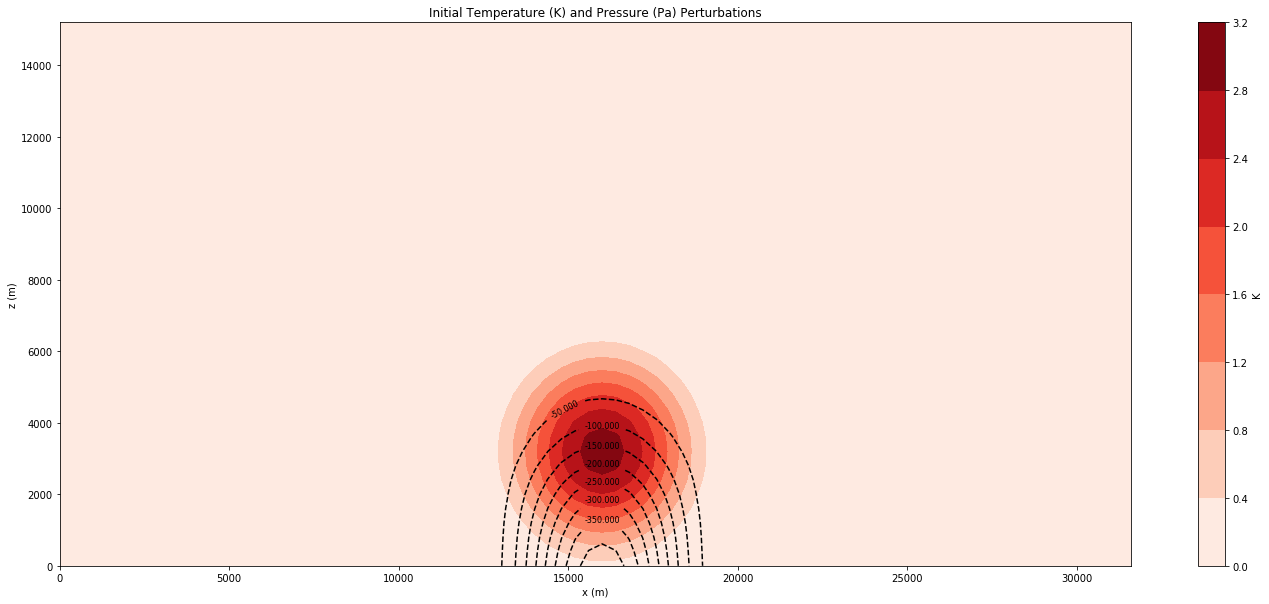

In [4]:
import numpy as np
import matplotlib.pyplot as plt

nx = 83
nz=42

dx=400.0
dz=400.0
dt=2.0
cp=1004.0
trigpi = 4.0*np.arctan(1.0)
rd=287.0
cv=cp-rd
rcpd= rd/cp
p0=100000.0
psurf=96500.0
g=9.81
pott = 343.0
Ttr=213.0
Lv=2.5*(10**6)
radx=4000.0
radz=4000.0
zcnt=3000.0
delt=3
cs=50.0
pisfc=(psurf/p0)**rcpd
y=np.empty([nz])
x=np.empty([nx])
for k in range(1,nz):
    y[k]=(k*dz-dz)
for i in range(1,nx):
    x[i]=(i*dx-dx)

#Base State Vectors

tb= np.empty([nz])
qb=np.empty([nz])
pb=np.empty([nz])
pib=np.empty([nz])
rhou=np.empty([nz])
rhow=np.empty([nz])
ub=np.empty([nz])
tbv=np.empty([nz])
tbvave=np.empty([nz])
tbav=np.empty([nz])
#prognostic arrays
thp=np.zeros([nx,nz])
th=np.zeros([nx,nz])
thm=np.zeros([nx,nz])
wp=np.zeros([nx,nz])
w=np.zeros([nx,nz])
wm=np.zeros([nx,nz])
up=np.zeros([nx,nz])
u=np.zeros([nx,nz])
um=np.zeros([nx,nz])
pip=np.zeros([nx,nz])
pi=np.zeros([nx,nz])
pim=np.zeros([nx,nz])
PPRT=np.zeros([nx,nz])
for i in range(0,nz):
    tb[i]=300.0
    qb[i]=0.0
    ub[i]=0.0
tbv=tb*(1.0+(.61*(qb)))

pib[1]=pisfc-((g*.5*dz)/(cp*tbv[1]))
for i in range(2, nz):
    tbvave[i]=0.5*(tbv[i]+tbv[i-1])
tbvave[0]=tbvave[1]
tbvave[nz-1]=tbvave[nz-2]
for i in range(2, nz):
    tbvave[k]=0.5*(tbv[i]+tbv[i-1])
    pib[i]=pib[i-1] - ((g*dz)/(cp*tbvave[i]))

rhou=(p0*pib**(cv/rd))/(rd*tbv)
for k in range(2, nz-1):
    rhow[k] = 0.5*(rhou[k] + rhou[k-1])    

tb[0] = tb[1]
tb[nz-1] = tb[nz-2]
pib[0] = pib[1]
pib[nz-1] = pib[nz-2]
rhou[0] = rhou[1]
rhou[nz-1] = rhou[nz-2]
rhow[0] = rhow[1]
rhow[nz-1] = rhow[nz-2]
imid=(nx)/2
for i in range(1,nx-1):
    for k in range(1,nz-1):
        argz=((dz*(k-1.5)-zcnt)/radz)**2
        argx=(dx*(i-imid)/radx)**2
        rad=np.sqrt(argz+argx)
        if rad < 1:
         th[i,k]=0.5*delt*(np.cos(trigpi*rad)+1)
        else:
         th[i,k]=0.0
for i in range(1,nx-1):  
    th[i,0]=th[i,1]
    th[i,nz-1]=th[i,nz-2]
for k in range(0,nz): 
    th[0,k]=th[nx-2,k]
    th[nx-1,k]=th[1,k]
thm= np.copy(th)


for i in range (1, nx-1):
    pi[i,nz-2] = 0.0
    pi[i,nz-1] = 0.0
    for k in range(nz-3, 0, -1):
        tup = th[i,k+1]/(tb[k+1]*tb[k+1])
        tdn = th[i][ k ]/(tb[k]*tb[k])
        pi[i,k] = pi[i,k+1]-0.5*(g/cp)*(tup+tdn)*dz

for i in range(1,nx-1):  
    pi[i,0]=pi[i,1]
    pi[i,nz-1]=pi[i,nz-2]
for k in range(0,nz): 
    pi[0,k]=pi[nx-2,k]
    pi[nx-1,k]=pi[1,k]

for i in range(0,nx):
    for k in range(0,nz):
        pim[i,k] = pi[i,k]
        PPRT[i,k] = pi[i,k]*cp*rhou[k]*tb[k]*(1.+0.61*qb[k])
pim = np.copy(pi)
levels=np.arange(-450,450,50)
import matplotlib.pyplot as plt
plt.figure(figsize=(24,10))
plt.clf()
plt.contourf(x[1:nx-2],y[1:nz-2],np.transpose(th[1:nx-2,1:nz-2]),cmap='Reds')
plt.colorbar(label='K')
CS=plt.contour(x[1:nx-2],y[1:nz-2],np.transpose(PPRT[1:nx-2,1:nz-2]),colors='k',levels=levels)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.clabel(CS,fontsize=8, inline=1)
plt.title('Initial Temperature (K) and Pressure (Pa) Perturbations')

In [5]:
print(np.min(PPRT))

-433.8753196315556


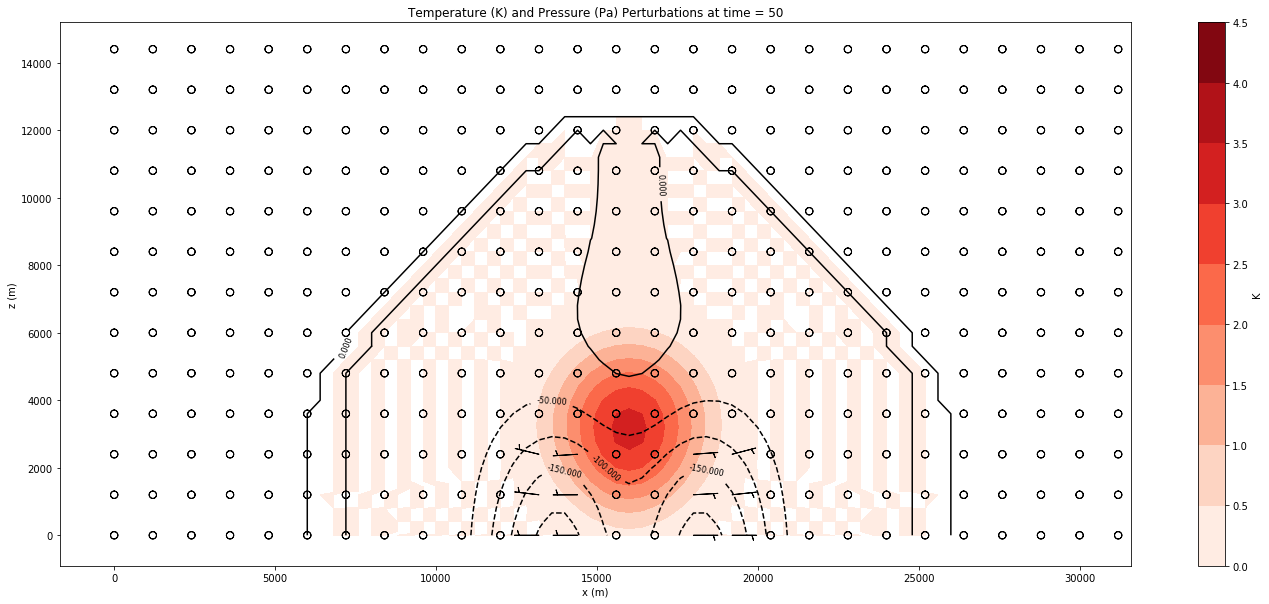

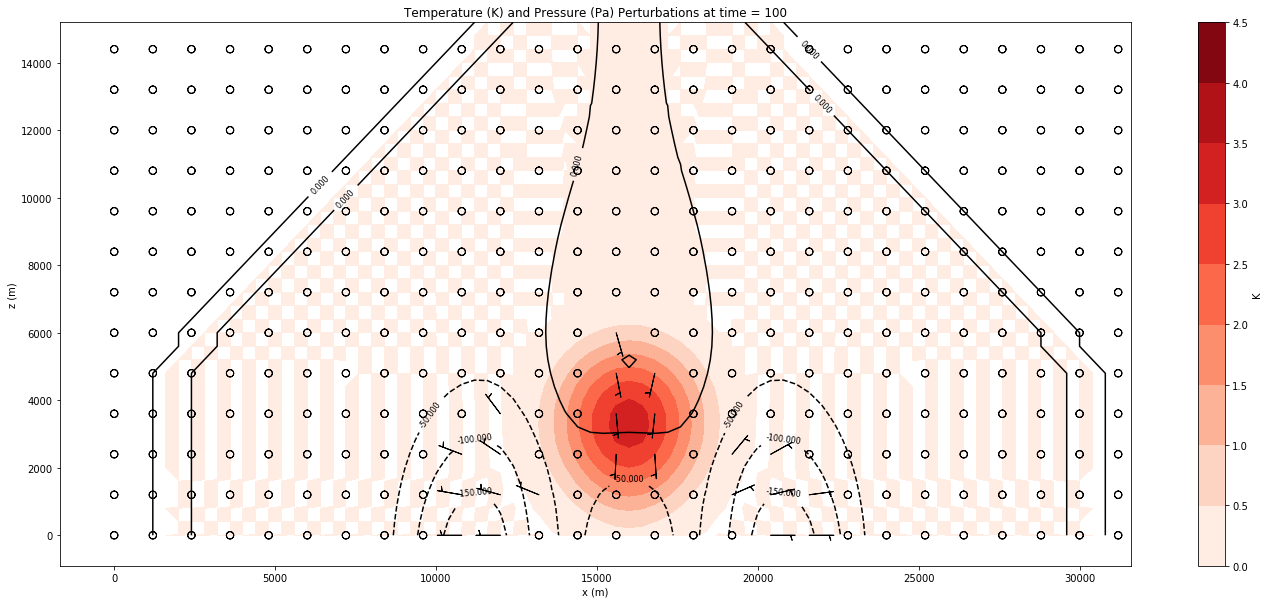

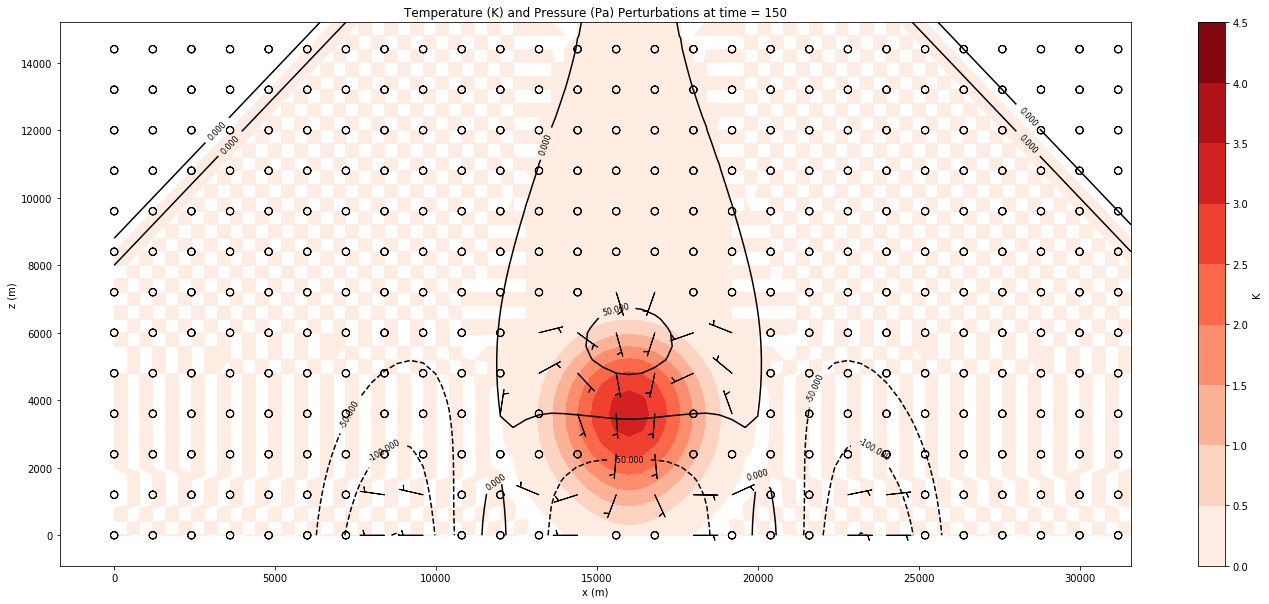

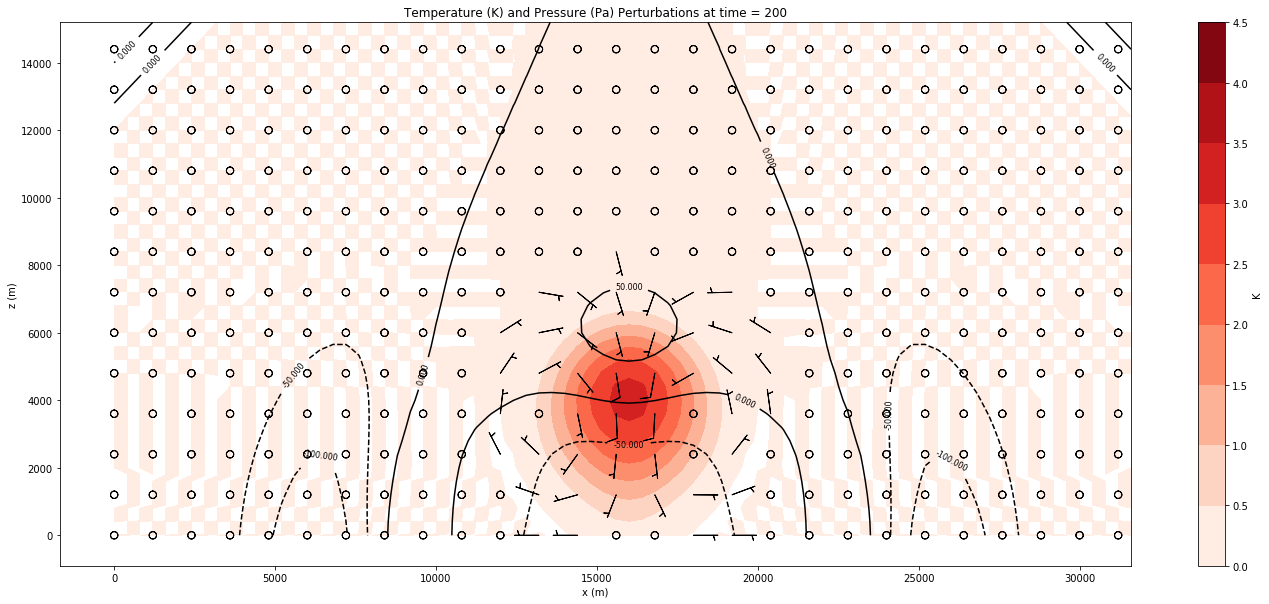

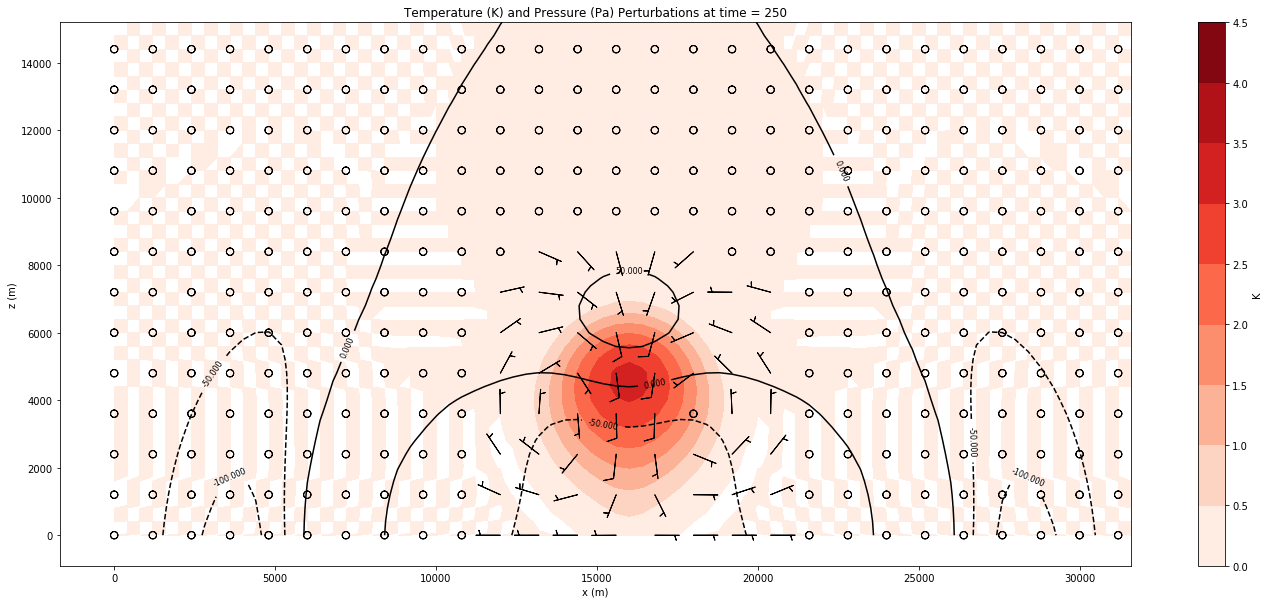

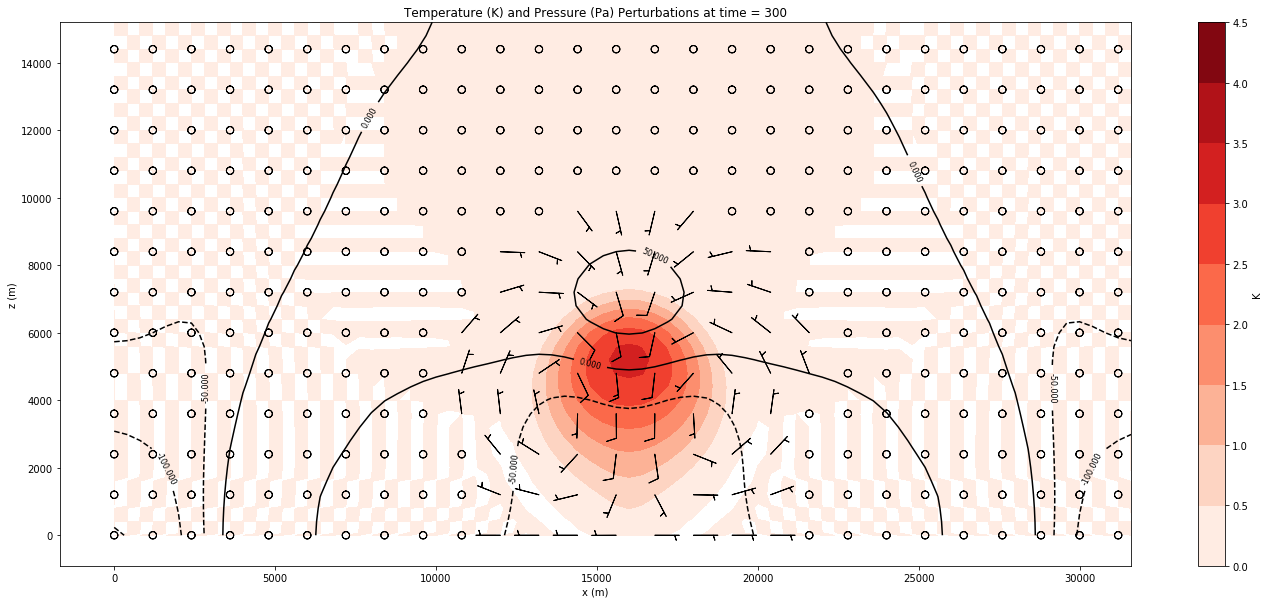

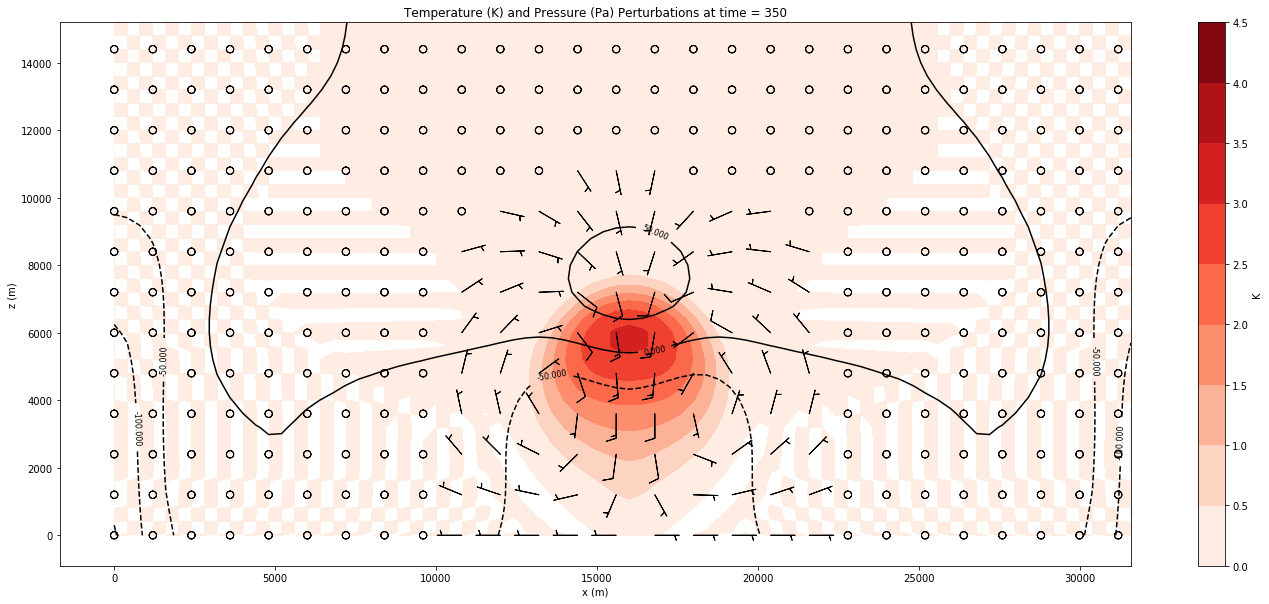

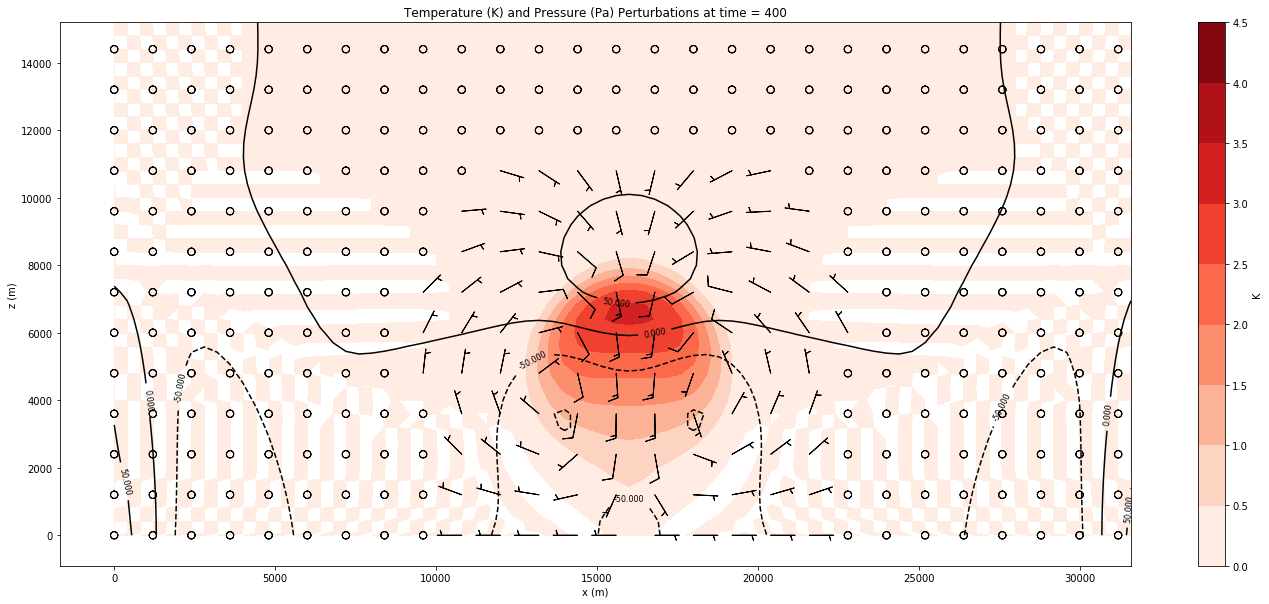

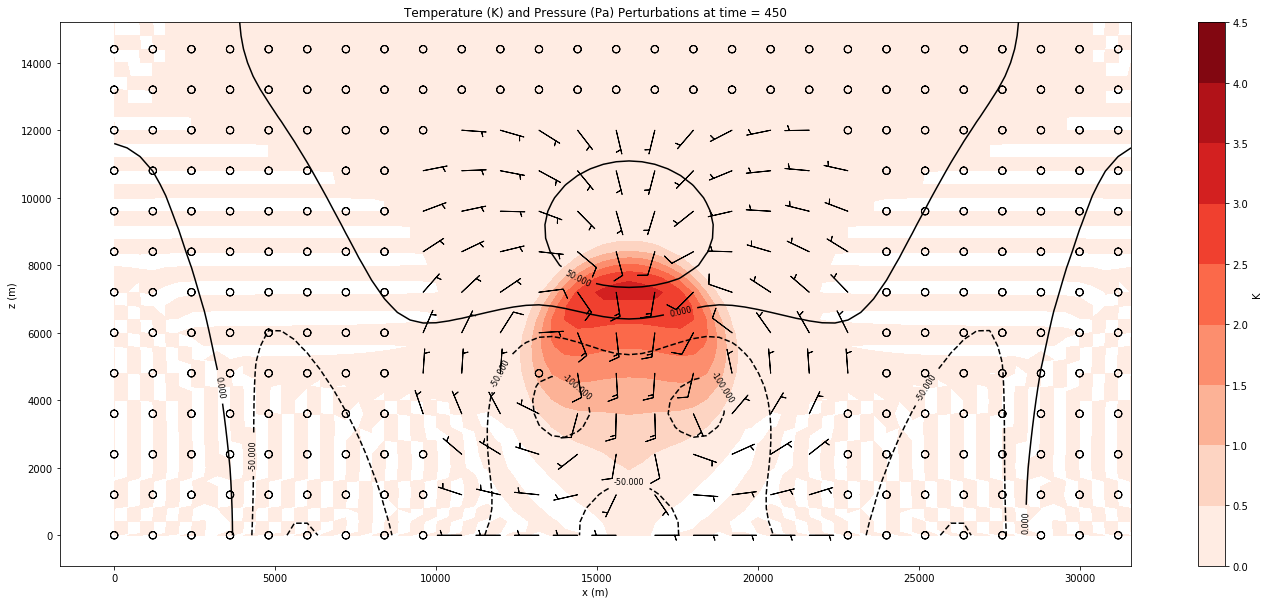

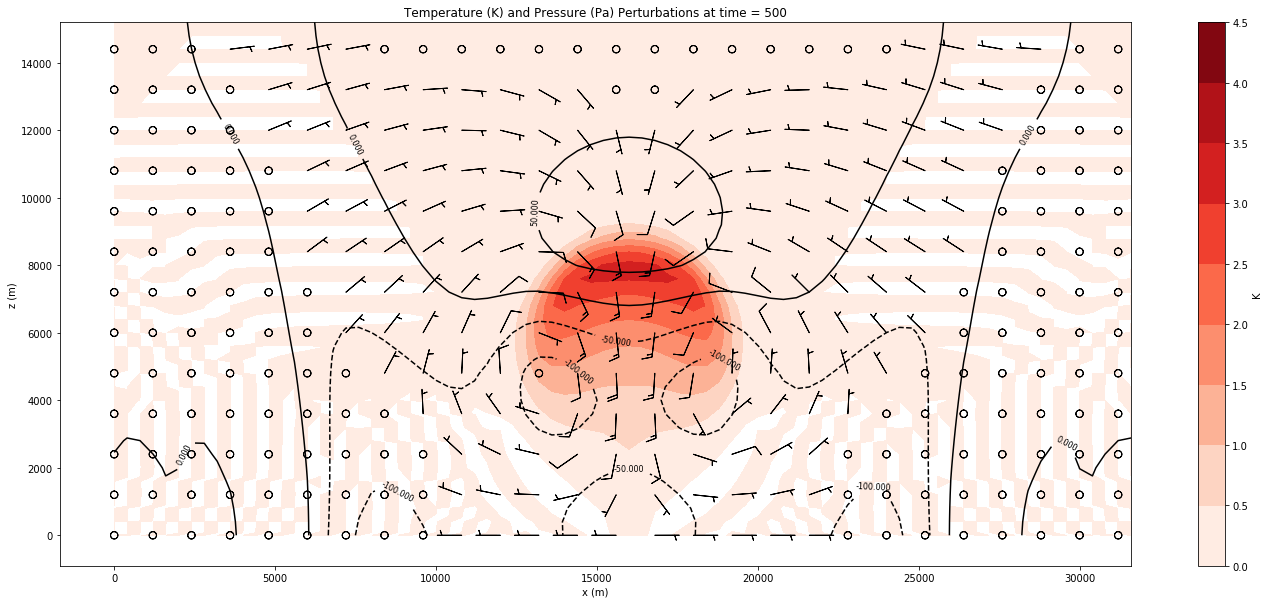

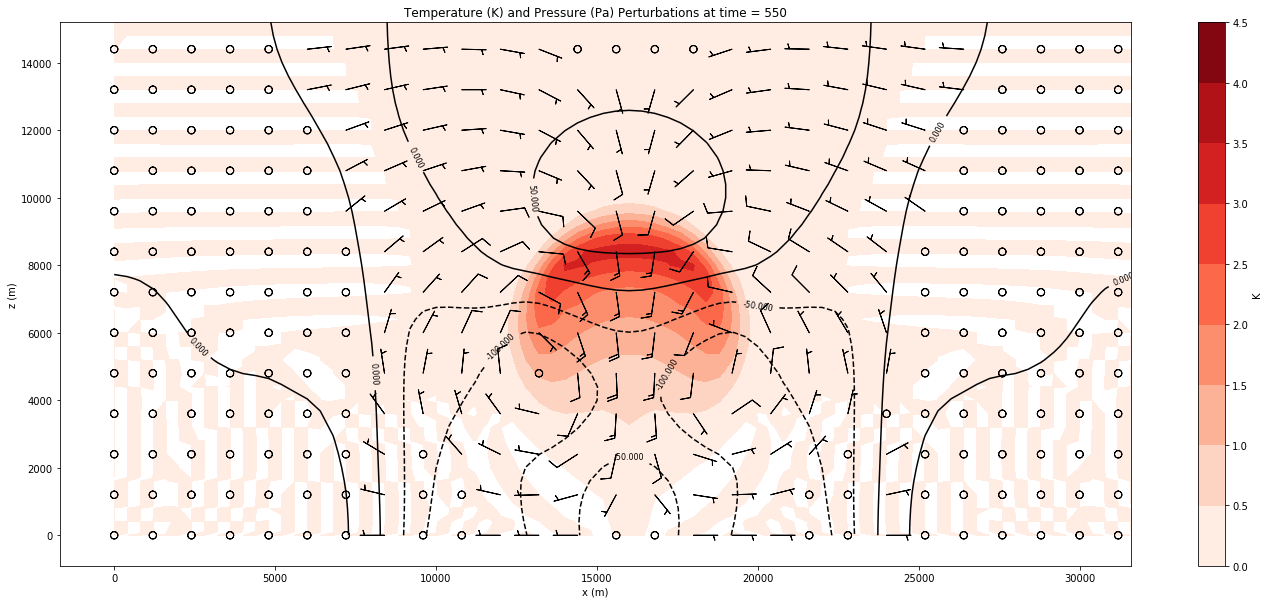

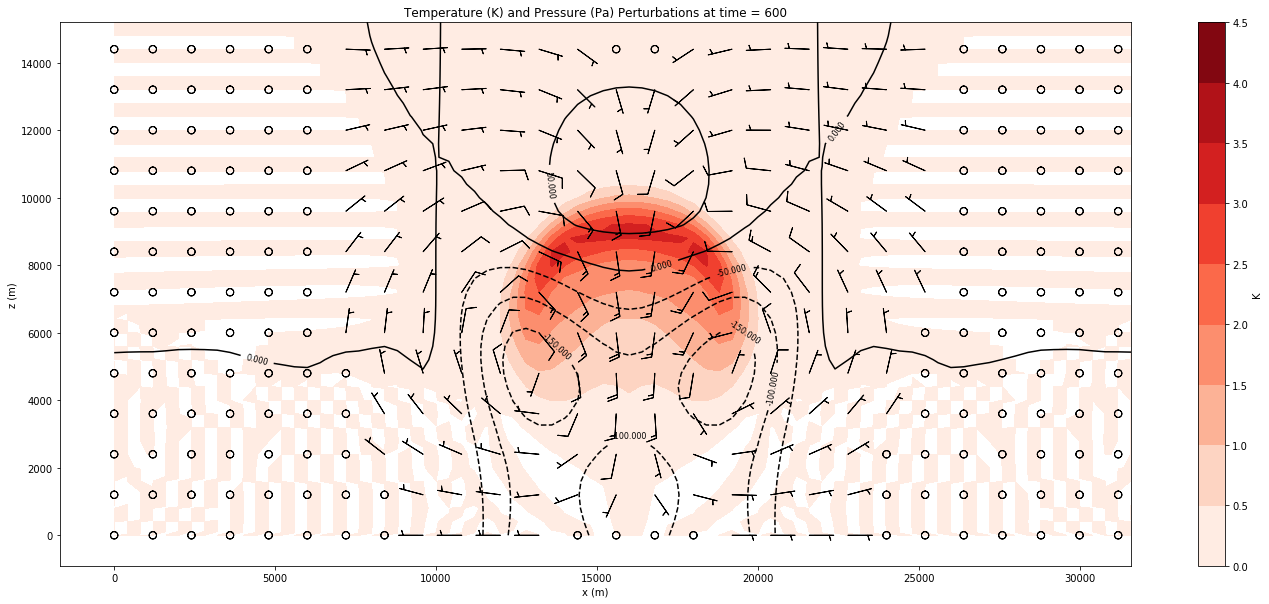

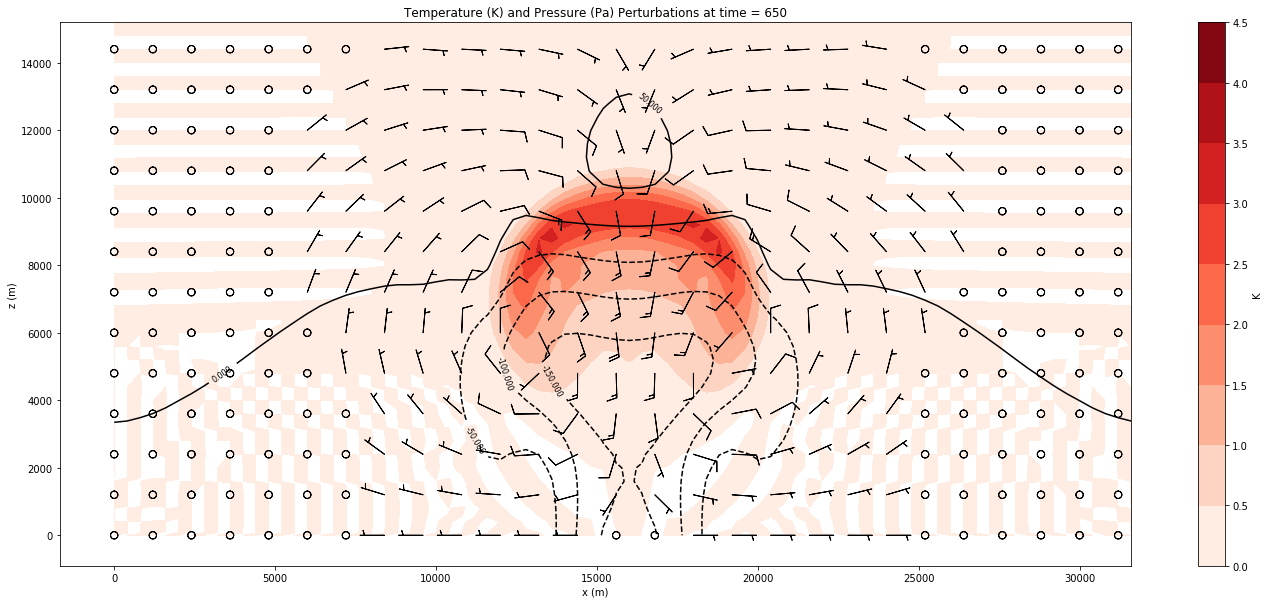

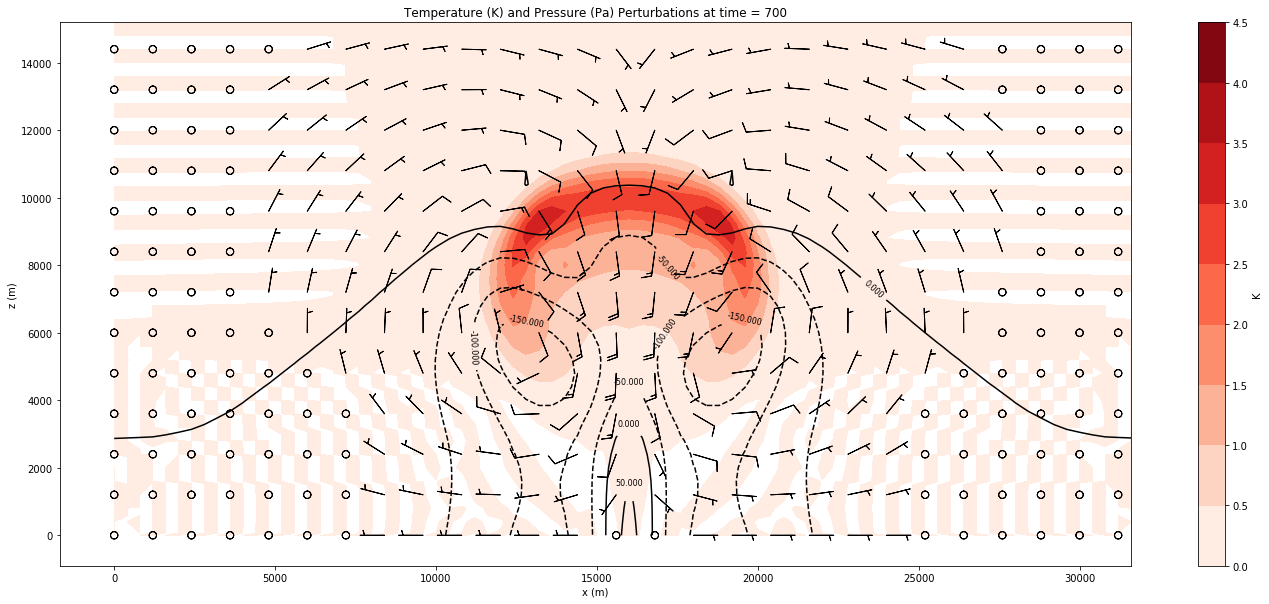

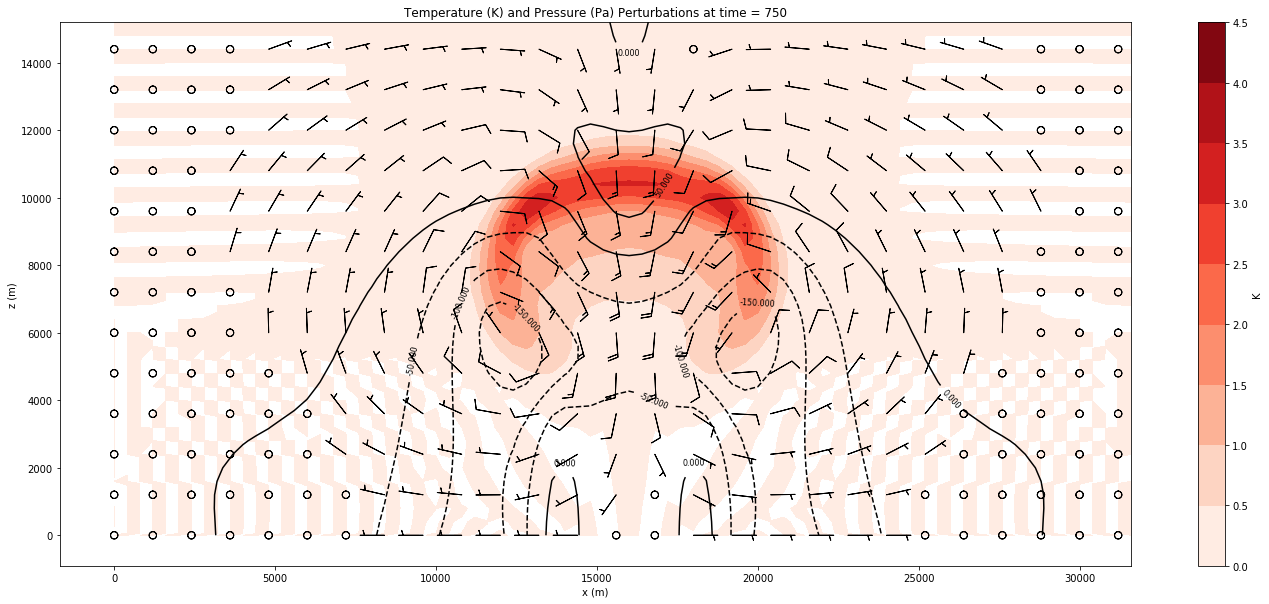

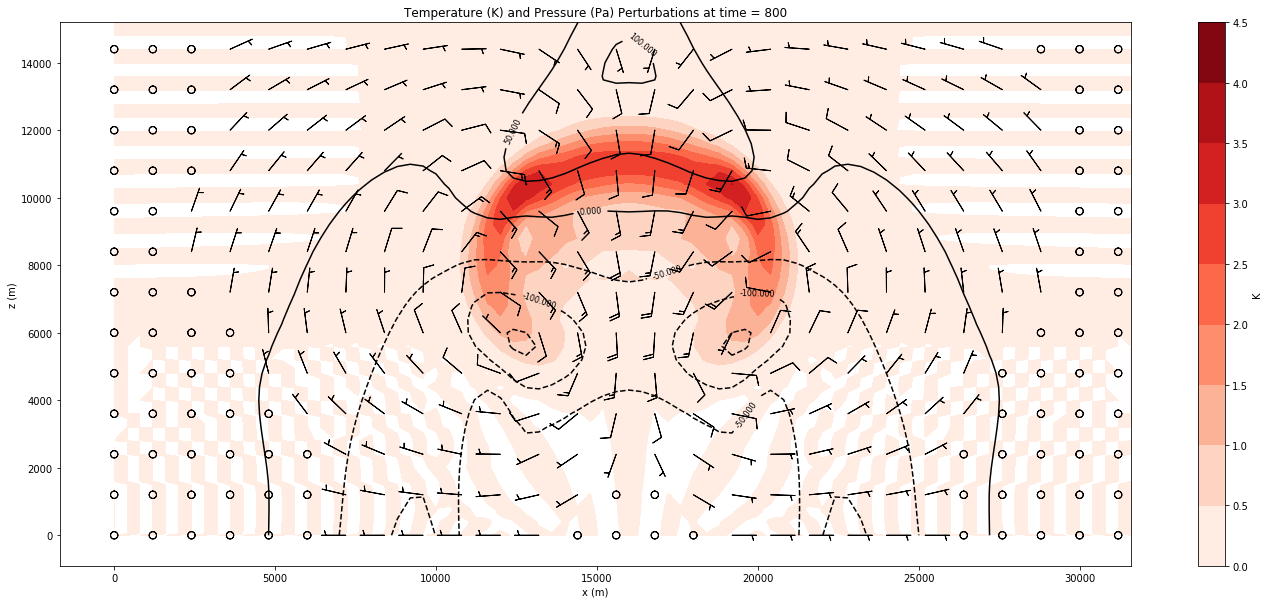

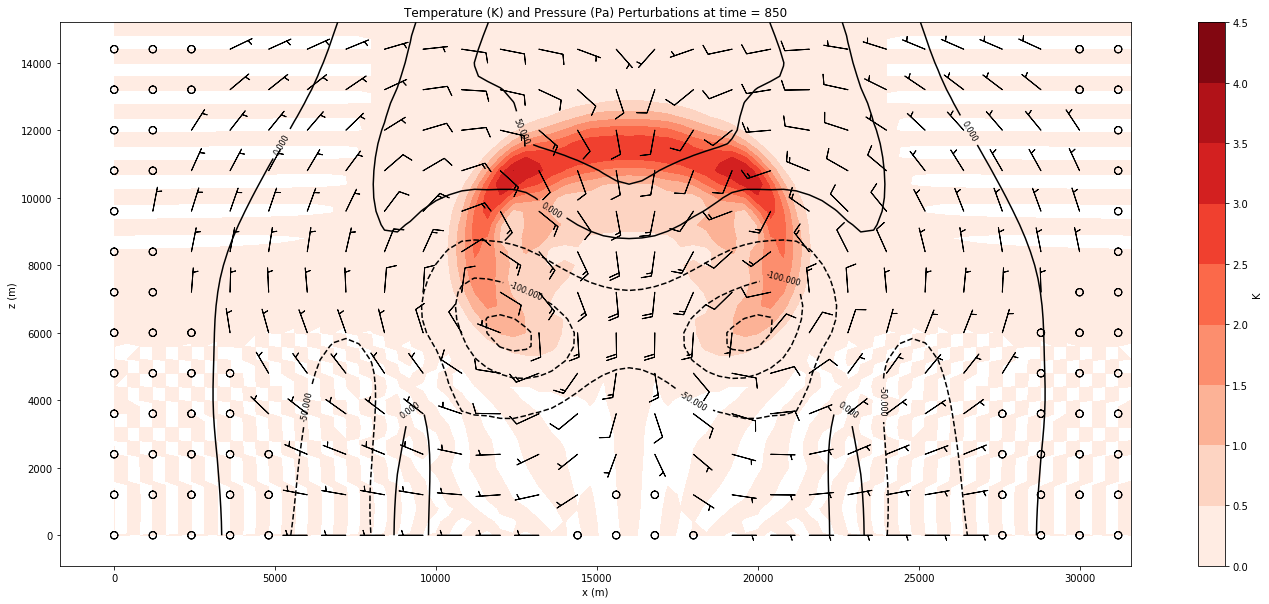

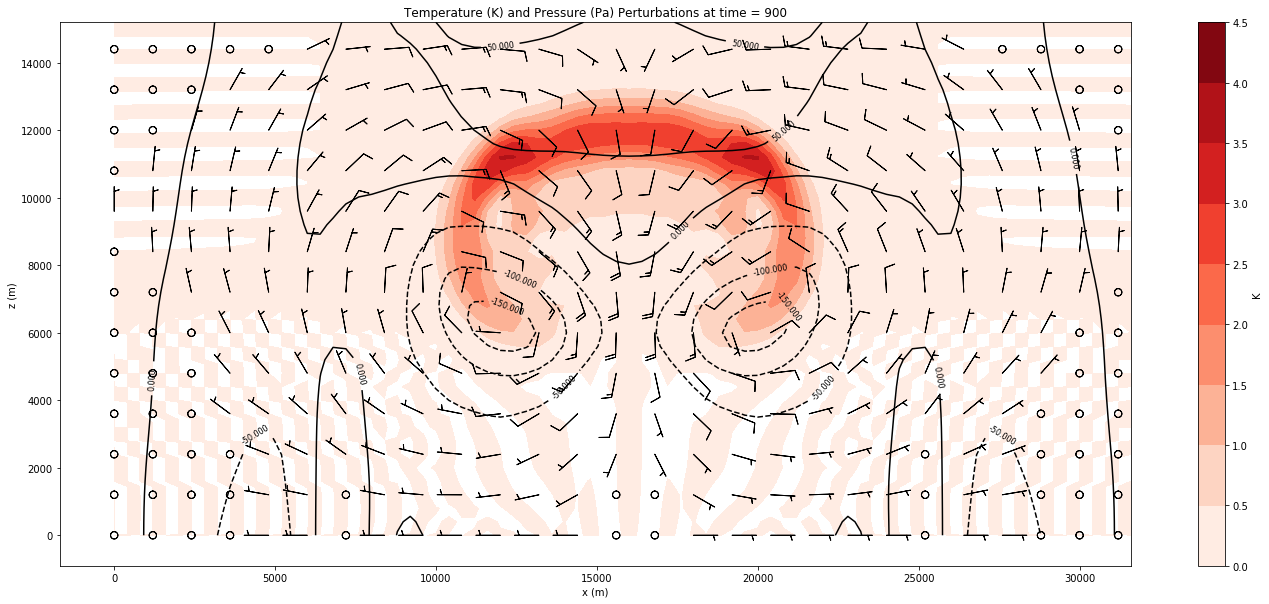

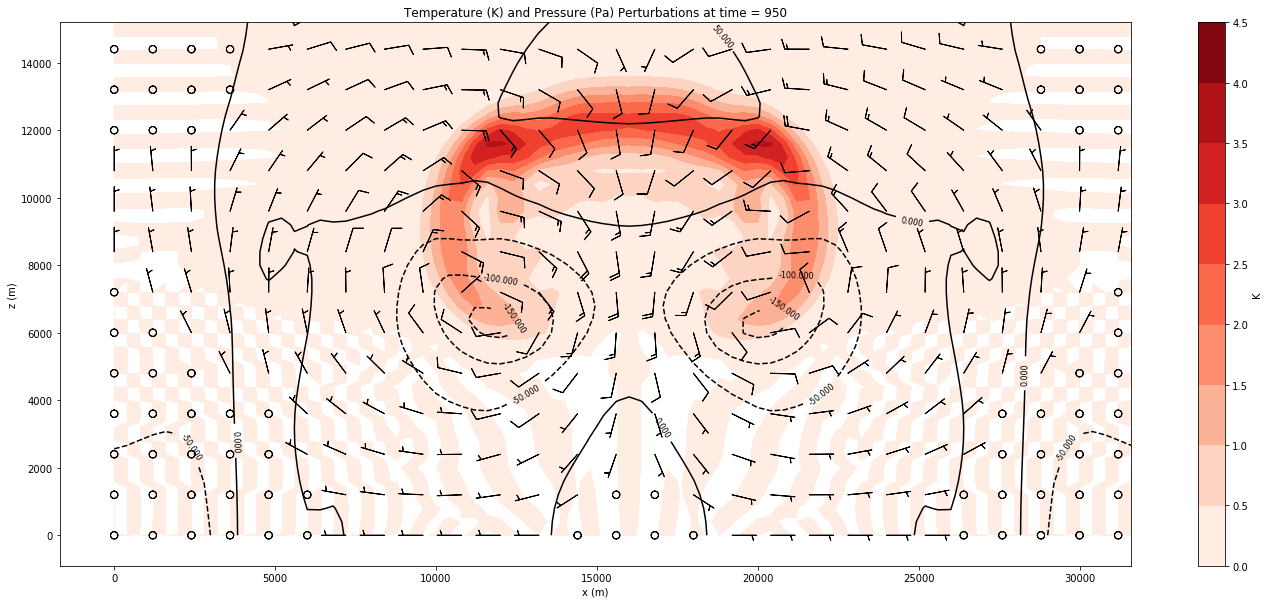

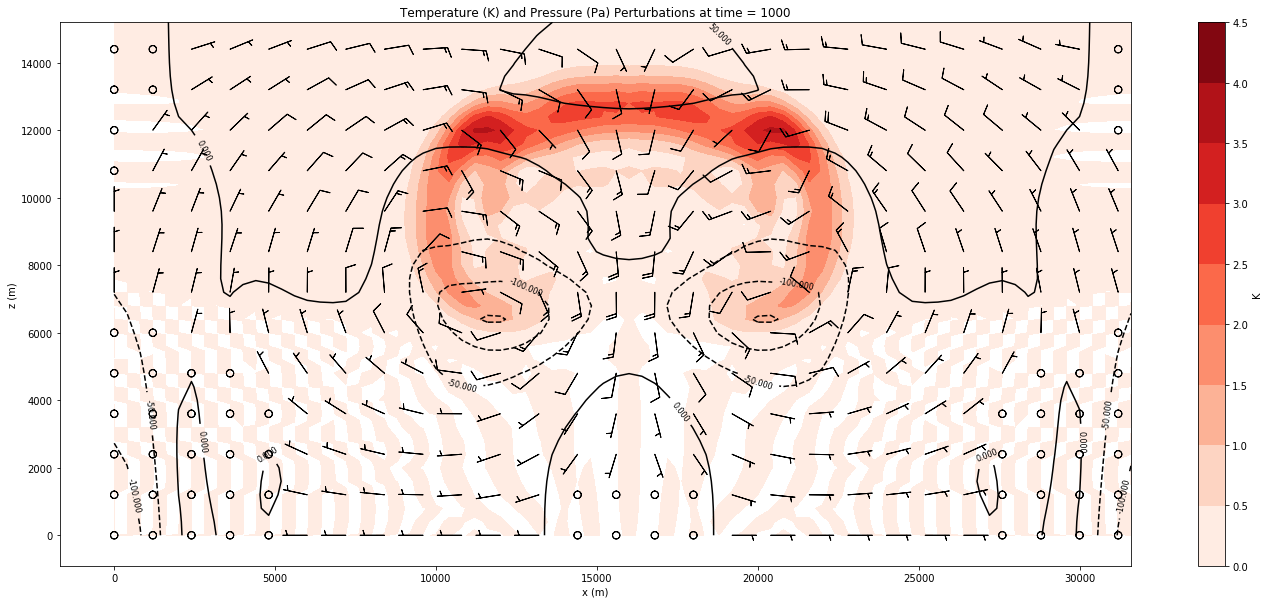

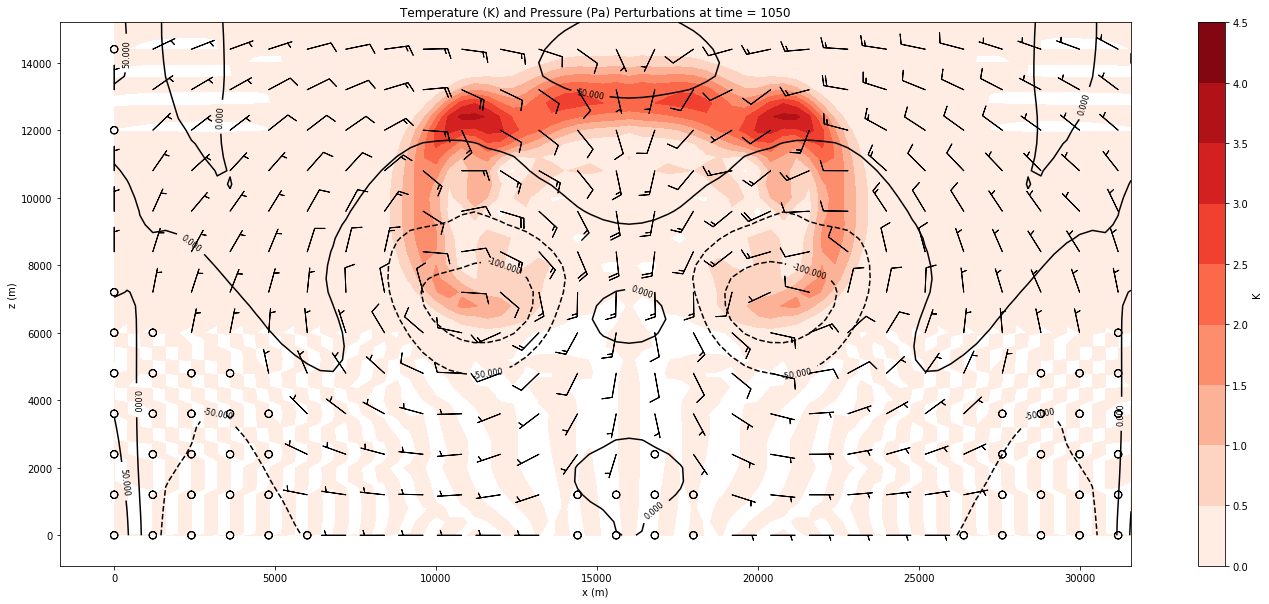

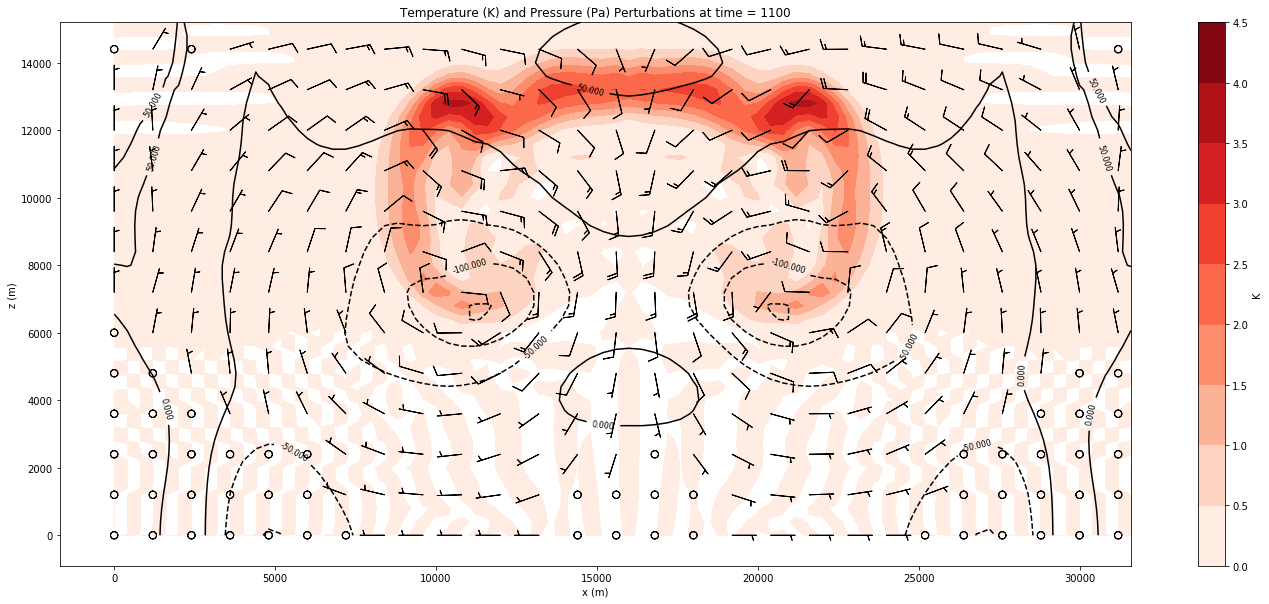

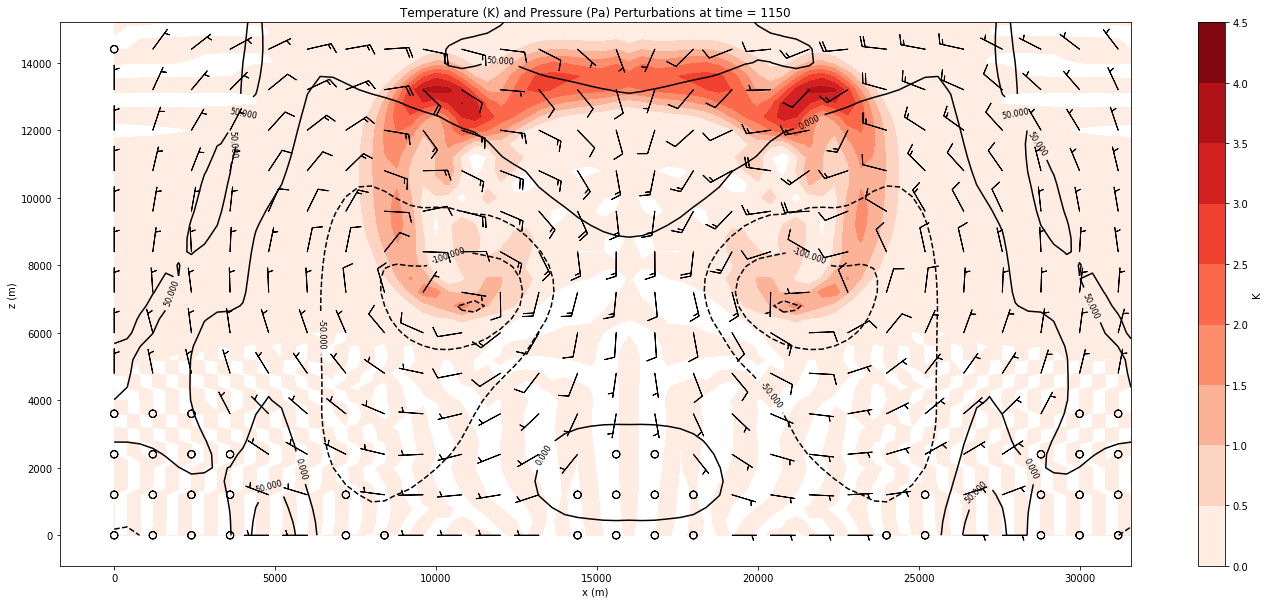

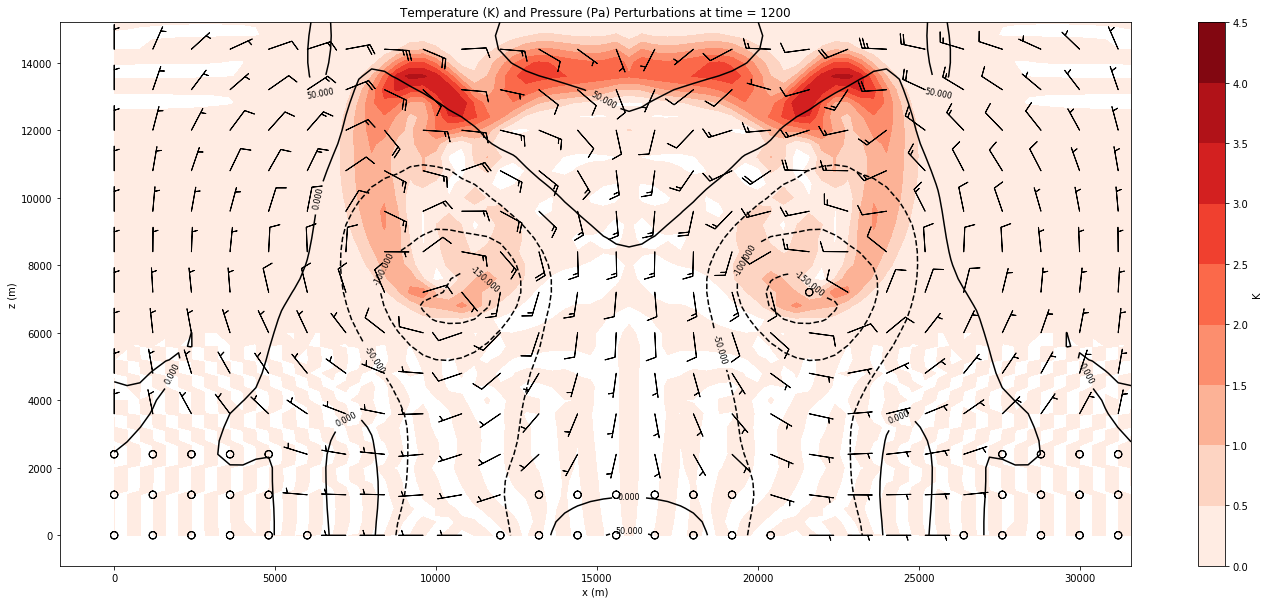

In [5]:
#This Cell steps the Navier-Stokes prognostic equations through time using the leapfrog scheme

d2t=dt
for t in range(2,1202,2):
    dtx=d2t/dx
    dtz=d2t/dz
    for i in range(1,nx-1,1):
        for k in range(1,nz-1,1):
            up[i,k] = um[i,k]-0.25*dtx*(((u[i+1,k]+u[i,k])**2.0)-((u[i-1,k]+u[i,k])**2.0))-0.25*dtz*(rhow[k+1]*(w[i,k+1]+w[i-1,k+1])*(u[i,k+1]+u[i ,k ]) -rhow[k ]*(w[i,k ]+w[i-1,k ])*(u[i,k ]+u[i ,k-1]))/rhou[k]-dtx*cp*tbv[k]*(pi[i,k]-pi[i-1,k])
    for i in range(1,nx-1):  
        up[i,0]=up[i,1]
        up[i,nz-1]=up[i,nz-2]
    for k in range(0,nz): 
        up[0,k]=up[nx-2,k]
        up[nx-1,k]=up[1,k]

    for i in range(1,nx-1):
        for k in range(1, nz-1):
            wp[i,k]=wm[i,k]-\
            .25*dtx*(((u[i+1,k]+u[i+1,k-1])*(w[i+1,k]+w[i,k])) - (u[i,k]+u[i,k-1])*(w[i,k]+w[i-1,k]))-\
            ((.25*dtz)/rhow[k])*((rhou[k]*(w[i,k+1]+w[i,k])**2) - (rhou[k-1]*(w[i,k]+w[i,k-1])**2)) -\
            .5*cp*dtz*((tbvave[k]+tbvave[k-1])*(pi[i,k]-pi[i,k-1])) +\
            .5*g*d2t*((th[i,k]/tbav[k])+(th[i,k-1]/tbav[k-1]))
    for i in range(1,nx-1):
        w[i,1] = w[i,nz-1] = 0
        wp[i,0]=wp[i,1]
        wp[i,nz-1]=wp[i,nz-2]
    for k in range(0,nz):
        wp[0,k]=wp[nx-2,k]
        wp[nx-1,k]=wp[1,k]
    
    for i in range(1,nx-1):
        for k in range(1, nz-1):
            thp[i,k] = thm[i,k] -\
            .5*dtx*((u[i+1,k])*(th[i+1,k]+th[i,k]) -u[i,k]*(th[i,k]+th[i-1,k])) -\
            .5*(1/rhou[k])*dtz*(rhow[k+1]*w[i,k+1]*(th[i,k+1]+th[i,k]) - rhow[k]*w[i,k]*(th[i,k]+th[i,k-1])) -\
            .5*dtz*((1/rhou[k])*(rhow[k+1]*w[i,k+1]*((tbav[k+1] - tbav[k]))+rhow[k]*w[i,k]*((tbav[k] - tbav[k-1]))))
    for i in range(1,nx-1):  
        thp[i,0]=thp[i,1]
        thp[i,nz-1]=thp[i,nz-2]
    for k in range(0,nz): 
        thp[0,k]=thp[nx-2,k]
        thp[nx-1,k]=thp[1,k]
    for i in range(1,nx-1):
        for k in range(1, nz-1):            
            pip[i,k] = pim[i,k] -\
            cs**2/(rhou[k]*cp*(tbvave[k])**2)*d2t*(
                ((1/dx)*(rhou[k]*tbvave[k]*(u[i+1,k]-u[i,k]))) +\
            ((1/dz)*((rhow[k+1]*w[i,k+1]*.5*(tbvave[k+1]+tbvave[k])) - (rhow[k]*w[i,k]*.5*(tbvave[k] + tbvave[k-1])))))
            
    for i in range(1,nx-1):  
        pip[i,0]=pip[i,1]
        pip[i,nz-1]=pip[i,nz-2]
    for k in range(0,nz): 
        pip[0,k]=pip[nx-2,k]
        pip[nx-1,k]=pip[1,k]
    for i in range(1,nx-1):
        for k in range(1, nz-1):
            PPRT[i,k] = pi[i,k]*cp*rhou[k]*tb[k]*(1.+0.61*qb[k])
    um = np.copy(u)
    u = np.copy(up)
    up *=0.0
    wm = np.copy(w)
    w = np.copy(wp)
    wp *=0.0
    pim = np.copy(pi)
    pi = np.copy(pip)
    pip *=0.0
    thm = np.copy(th)
    th = np.copy(thp)
    thp *=0.0
    levels=np.arange(-450,450,50)
    tlevs=np.arange(0,5,.5)
    if t % 50 == 0:
        plt.figure(figsize=(24,10))
        plt.clf()
        plt.contourf(x[1:nx-2],y[1:nz-2],np.transpose(th[1:nx-2,1:nz-2]),tlevs,cmap='Reds')
        plt.colorbar(label='K')
        CS=plt.contour(x[1:nx-2],y[1:nz-2],np.transpose(PPRT[1:nx-2,1:nz-2]),colors='k',levels=levels)
        plt.barbs(x[1:nx-2:3],y[1:nz-2:3],np.transpose(u[1:nx-2:3,1:nz-2:3]),np.transpose(w[1:nx-2:3,1:nz-2:3]))
        plt.xlabel('x (m)')
        plt.ylabel('z (m)')
        plt.clabel(CS,fontsize=8, inline=1)
        plt.title('Temperature (K) and Pressure (Pa) Perturbations at time = {0}'.format(t))  
        plt.show()
        #plt.savefig('pert_{0}_seconds'.format(t),dpi=120)
    d2t=dt*2

In [68]:
print(dtx)

0.01
